In [1]:
%%capture
pip install torch numpy pandas pytorch-lightning torchvision Pillow torchinfo

In [69]:
import os

import torch
import torchvision
import pandas as pd
import pytorch_lightning as pl
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

from torchvision.transforms import ToPILImage, ToTensor, transforms, Normalize
from torchvision.transforms.functional import rgb_to_grayscale
from torch.utils.data import DataLoader, Dataset, random_split
from torchinfo import summary
from torchmetrics import CharErrorRate
from pytorch_lightning import seed_everything

# 1. Подготовка данных

In [3]:
BATCH_SIZE = 32

In [4]:
class CaptchaDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.captcha_frames = pd.DataFrame([], columns=["path", "label"])
        self.transform = transform

        for path in os.listdir(self.root_dir):
            new_captcha = pd.DataFrame(
                [[os.path.join(self.root_dir, path)] + [path.split(".")[0].lower()]],
                columns=["path", "label"],
            )
            self.captcha_frames = self.captcha_frames.append(
                new_captcha, ignore_index=True
            )

    def __len__(self):
        return len(self.captcha_frames)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        label = self.captcha_frames.iloc[idx, 1]
        with Image.open(self.captcha_frames.iloc[idx, 0]) as img:
            img = img.convert("RGB")
            if self.transform is None:
                return img.copy(), label
            return self.transform(img), label


Найдем среднее и дисперсию в нашем датасете.

In [13]:
captcha_dataset = CaptchaDataset("/kaggle/input/captcha-made/samples/samples", transform=transforms.Compose([ToTensor(), Normalize(std=0.7, mean=0.4)]))

train_size = round(len(captcha_dataset) * 0.7)
val_size = round(len(captcha_dataset) * 0.1)
test_size = len(captcha_dataset) - train_size - val_size
train, val, test = random_split(captcha_dataset, lengths=[train_size, val_size, test_size])

train_loader = DataLoader(
    dataset=train, batch_size=BATCH_SIZE, num_workers=2, shuffle=True,
)
test_loader = DataLoader(
    dataset=test, batch_size=BATCH_SIZE, num_workers=2, shuffle=False
)
val_loader = DataLoader(
    dataset=val, batch_size=BATCH_SIZE, num_workers=2, shuffle=False
)

# 2. Создание и обучение модели

In [14]:
ALPHABET = 'abcdefghijklmnopqrstuvwxyz0123456789'

Найдем статью по картинке из задания и реализуем описанную в ней архитектуру. Вместо оптимизатора `Adadelta` возьмем `Adam` с `weight_decay`, потому что с первым сеть по какой-то причине не учится совсем. Кроме того, добавим `Dropout(0.5)` слой после сверточной подсети, для ускорения сходимости.

In [15]:
# Architecture influenced by paper: https://arxiv.org/pdf/1507.05717.pdf


class FCNNnBLSTM(nn.Module):
    def __init__(self, alphabet_size=36):
        super(FCNNnBLSTM, self).__init__()
        self.conv = nn.Sequential(
            # CONV 1
            nn.Conv2d(3, 32, (3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), 2),
            # CONV 2
            nn.Conv2d(32, 64, (3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), 2),
            # CONV 3
            nn.Conv2d(64, 128, (3, 3), stride=1, padding=1),
            nn.ReLU(),
            # CONV 4
            nn.Conv2d(128, 256, (3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((1, 2), 2),
            # CONV 5
            nn.Conv2d(256, 512, (3, 3), stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # CONV 6
            nn.Conv2d(512, 512, (3, 3), stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d((1, 2), 2),
            # CONV 7
            nn.Conv2d(512, 512, (2, 2), stride=1, padding=0),
            nn.MaxPool2d(kernel_size=(1, 2)),
            # DROPOUT
            nn.Dropout(0.5),
        )

        self.map2seq = nn.Linear(1024, 256)

        self.lstm_0 = nn.LSTM(256, 256, bidirectional=True)
        self.lstm_1 = nn.LSTM(512, 256, bidirectional=True)

        self.transcriptor = nn.Linear(512, alphabet_size)

    def forward(self, input):
        conv = self.conv(input)
        conv = conv.permute(0, 3, 1, 2)
        map_input = conv.view(conv.size(0), conv.size(1), -1)
        seq = self.map2seq(map_input)
        seq, _ = self.lstm_0(seq)
        seq, _ = self.lstm_1(seq)
        gen_t = self.transcriptor(seq)

        return gen_t.permute(0, 2, 1)

In [16]:
summary(FCNNnBLSTM(), input_size=(BATCH_SIZE, 3, 50, 200))

Layer (type:depth-idx)                   Output Shape              Param #
FCNNnBLSTM                               [32, 36, 5]               --
├─Sequential: 1-1                        [32, 512, 2, 5]           --
│    └─Conv2d: 2-1                       [32, 32, 50, 200]         896
│    └─ReLU: 2-2                         [32, 32, 50, 200]         --
│    └─MaxPool2d: 2-3                    [32, 32, 25, 100]         --
│    └─Conv2d: 2-4                       [32, 64, 25, 100]         18,496
│    └─ReLU: 2-5                         [32, 64, 25, 100]         --
│    └─MaxPool2d: 2-6                    [32, 64, 12, 50]          --
│    └─Conv2d: 2-7                       [32, 128, 12, 50]         73,856
│    └─ReLU: 2-8                         [32, 128, 12, 50]         --
│    └─Conv2d: 2-9                       [32, 256, 12, 50]         295,168
│    └─ReLU: 2-10                        [32, 256, 12, 50]         --
│    └─MaxPool2d: 2-11                   [32, 256, 6, 25]          --
│

In [29]:
class CaptchaRecognizer(pl.LightningModule):
    def __init__(self, net, criterion, alphabet, test_metric=CharErrorRate()):
        super().__init__()
        self.net = net.to(self.device)
        self.criterion = criterion
        self.test_metric = test_metric
        self.alphabet_map = {alphabet[i]: i + 1 for i in range(len(alphabet))}
        self.idx_map = {i + 1: alphabet[i] for i in range(len(alphabet))}

    def encode_labels(self, labels):
        lengths = [len(label) for label in labels]
        encoded = [
            torch.LongTensor([self.alphabet_map[char] for char in label])
            for label in labels
        ]

        return (
            nn.utils.rnn.pad_sequence(
                sequences=encoded, batch_first=True, padding_value=0
            ),
            torch.LongTensor(lengths),
        )
    
    def decode_labels(self, logits):
        preds = logits.argmax(1).detach().cpu().numpy()
        words = [
            ''.join(self.idx_map[token] for token in pred)
            for pred in preds
        ]
        
        return words
        
    
    def calculate_loss(self, batch):
        images, labels = batch
        preds = self.net(images.to(self.device))
        encoded_labels, lengths = self.encode_labels(labels)
    
        loss = self.criterion(preds.to(self.device), encoded_labels.to(self.device))
        
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.calculate_loss(batch)
        self.log("train_loss", loss)

        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self.calculate_loss(batch)
        self.log("val_loss", loss)

        return loss
    
    def test_step(self, batch, batch_idx):
        data, labels = batch
        logits = self.net(data.to(self.device))
        words = self.decode_labels(logits)
        metric = self.test_metric(words, labels)
        
        self.log("test_CER", metric)

        return metric

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-4)

        return optimizer


In [37]:
cr = CaptchaRecognizer(
    net=FCNNnBLSTM(),
    criterion=nn.CrossEntropyLoss(),
    alphabet=ALPHABET,
)

trainer = pl.Trainer(max_epochs=100, accelerator="gpu", devices=1, log_every_n_steps=5)
trainer.fit(model=cr, train_dataloaders=train_loader, val_dataloaders=val_loader)
train_metrics = trainer.logged_metrics

test_loss = trainer.test(dataloaders=test_loader, ckpt_path='best')

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_CER          │   0.026168223470449448    │
└───────────────────────────┴───────────────────────────┘

# 3. Подсчет метрик

Подробный отчет о поведении лосса во время обучения можно посмотреть в `tensorboard`, который красиво отрисовывает залоггированные метрики, но по причине его интерактивности вставить в ноутбук не получится.

In [43]:
print(f"Train loss : {train_metrics['train_loss'].item()}")
print(f"Train loss : {train_metrics['val_loss'].item()}")
print(f"Final test CER = {trainer.logged_metrics['test_CER'].item()}")

Train loss : 0.010717297904193401
Train loss : 0.12364913523197174
Final test CER = 0.026168223470449448


# 4. Анализ ошибок модели

Найдем все объекты тестового корпуса, на которых мы ошиблись.

In [46]:
checkpoint = trainer.checkpoint_callback.best_model_path
cr = CaptchaRecognizer.load_from_checkpoint(
    checkpoint,
    net=FCNNnBLSTM(),
    criterion=nn.CrossEntropyLoss(),
    alphabet=ALPHABET,
)

net = cr.net 
net.eval()

FCNNnBLSTM(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (15): BatchNorm2d(512, eps=1e-05, moment

In [49]:
test_loader = DataLoader(
    dataset=test, batch_size=BATCH_SIZE, num_workers=2, shuffle=False
)
batch_metrics = []

for images, labels in test_loader:
    logits = net(images)
    words = cr.decode_labels(logits)
    
    for image, word, label in zip(images, words, labels):
        if word != label:
            batch_metrics.append((image, word, label, cr.test_metric(word, label)))

Выведем ошибки на тестовом корпусе в порядке уменьшения целевой метрики

Predicted label: wfb3x
True label: mfb3x
CER = 0.20000000298023224


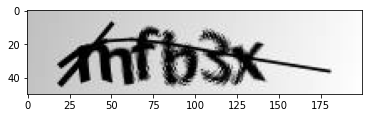

Predicted label: c4826
True label: c482b
CER = 0.20000000298023224


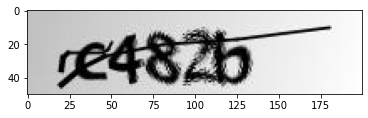

Predicted label: 67gdw
True label: 6fgdw
CER = 0.20000000298023224


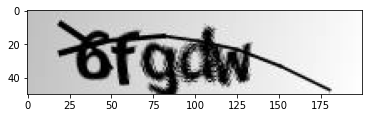

Predicted label: ny3dx
True label: ny3dw
CER = 0.20000000298023224


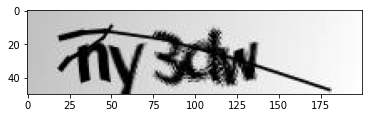

Predicted label: ggd7p
True label: ggd7m
CER = 0.20000000298023224


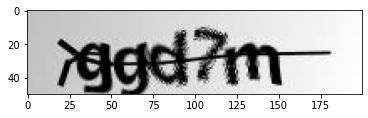

Predicted label: 3xcgb
True label: 3xcgg
CER = 0.20000000298023224


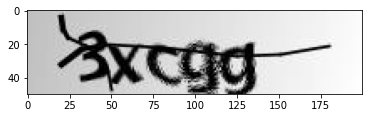

Predicted label: c3532
True label: c3572
CER = 0.20000000298023224


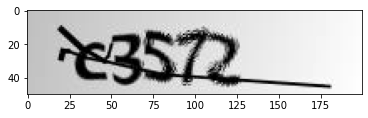

Predicted label: ec436
True label: dc436
CER = 0.20000000298023224


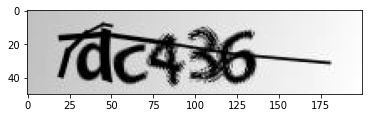

Predicted label: m4d8g
True label: m4g8g
CER = 0.20000000298023224


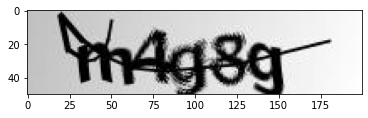

Predicted label: m756f
True label: m75bf
CER = 0.20000000298023224


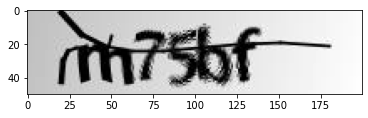

Predicted label: 4w6nw
True label: 4w6mw
CER = 0.20000000298023224


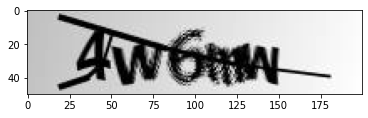

Predicted label: ce8xm
True label: xe8xm
CER = 0.20000000298023224


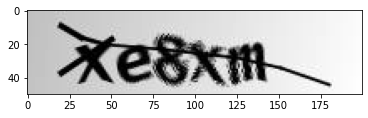

Predicted label: 7pn5b
True label: 7pn5g
CER = 0.20000000298023224


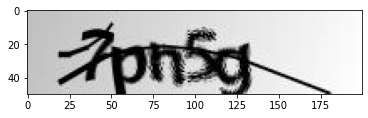

Predicted label: wym25
True label: wyc25
CER = 0.20000000298023224


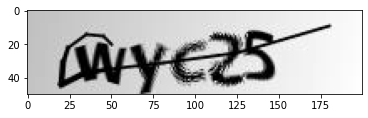

Predicted label: 6m52g
True label: 6m5eg
CER = 0.20000000298023224


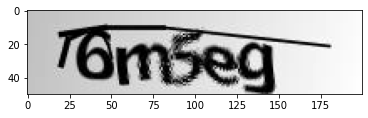

Predicted label: n3gmg
True label: n2gmg
CER = 0.20000000298023224


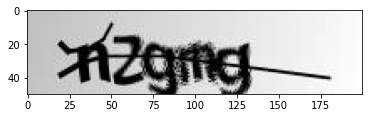

Predicted label: pf5nb
True label: pf5ng
CER = 0.20000000298023224


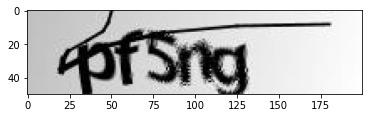

Predicted label: e46yx
True label: e46yw
CER = 0.20000000298023224


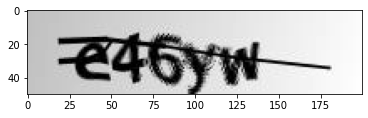

Predicted label: ncfgc
True label: ncfgb
CER = 0.20000000298023224


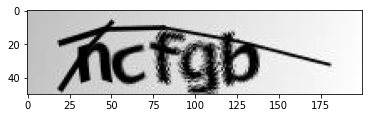

Predicted label: 5bg86
True label: 5bg8f
CER = 0.20000000298023224


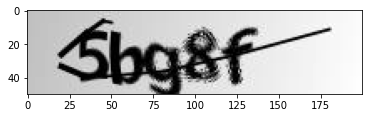

Predicted label: b5nmp
True label: b5nmm
CER = 0.20000000298023224


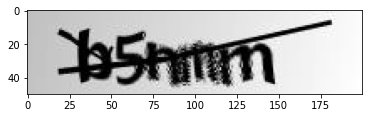

Predicted label: e2fb7
True label: c2fb7
CER = 0.20000000298023224


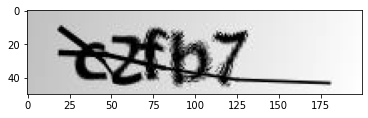

Predicted label: edcc3
True label: cdcb3
CER = 0.4000000059604645


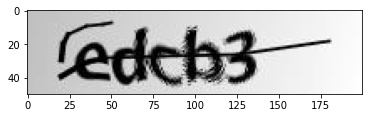

Predicted label: 4y2y5
True label: 4m2w5
CER = 0.4000000059604645


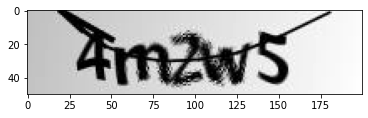

Predicted label: w73fn
True label: w52fn
CER = 0.4000000059604645


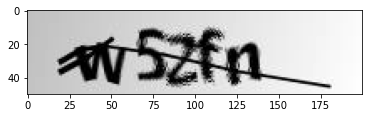

In [81]:
batch_metrics.sort(key=lambda x: x[3].item())

for image, word, label, cer in batch_metrics:
    # обратная операция Normalize
    print('=' * 50)
    print(f'Predicted label: {word}')
    print(f"True label: {label}")
    print(f"CER = {cer}")
    image = image * 0.7 + 0.4
    image = image.cpu().numpy()[0]
    plt.imshow(image, cmap='gray')
    plt.show()

Полученные ошибки на тестовом корпусе довольно интерпретируемы и связаны с неудачным расположением линий на этих изображениях. Таким образом, наша сеть путает например символы `5` и `7`, а так же `c` и `e`, в местах, где различить их было бы довольно сложно даже человеку. Возможно, некоторых из этих ошибок мы могли бы избежать, если бы воспользовались аугментациями на обучающем корпусе.